In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [46]:
def get_file(name):
    f = open(name, "r")
    content=f.read()
    lines=content.split("\n")
    
    l_points=[]
    
    for l in lines:
        vec=torch.empty(6)
        l=l.split(" ")
        cpt=0
        for number in (l):
            if len(number)>3:
                vec[cpt]=float(number)
                cpt+=1
        if cpt>2:
            l_points.append(vec)
    
    res=torch.empty((len(l_points),6))
    for idx_tensor,tensor in enumerate(l_points):
        res[idx_tensor]=tensor
    return res
        

points_c=get_file("./data/horse.npts")

In [47]:
def sphere_points_and_normals_torch(radius, num_points_theta, num_points_phi):
    """
    Generate coordinates of points on the surface of a sphere and their normals using PyTorch.

    Parameters:
    radius (float): The radius of the sphere.
    num_points_theta (int): The number of points to generate along the azimuth angle (θ).
    num_points_phi (int): The number of points to generate along the polar angle (φ).

    Returns:
    torch.Tensor: A tensor of shape (num_points_theta * num_points_phi, 6) containing the coordinates of the points and their normals.
    """
    # Create tensors for azimuth and polar angles
    theta = torch.linspace(0, 2 * torch.pi, num_points_theta)
    phi = torch.linspace(0, torch.pi, num_points_phi)

    # Create a grid of angles
    theta, phi = torch.meshgrid(theta, phi)

    # Calculate the x, y, and z coordinates for each point
    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    # For a sphere centered at the origin, the normals are the same as the coordinates
    normals = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)

    # Normalize the normals
    normals = normals / torch.norm(normals, dim=1, keepdim=True)

    # Reshape and stack the coordinates and normals
    points_with_normals = torch.cat((x.flatten().unsqueeze(1), y.flatten().unsqueeze(1), z.flatten().unsqueeze(1), normals), dim=1)
    return points_with_normals


def plot_sphere_with_normals(points_with_normals, show_normals=True, normal_length=0.1):
    """
    Plot the points on a sphere and optionally their normals.

    Parameters:
    points_with_normals (torch.Tensor): A tensor of shape (n, 6) containing the coordinates and normals of the points.
    show_normals (bool): If True, plot the normals.
    normal_length (float): The length of the normal vectors in the plot.
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Extract coordinates and normals
    x, y, z = points_with_normals[:, 0], points_with_normals[:, 1], points_with_normals[:, 2]
    nx, ny, nz = points_with_normals[:, 3], points_with_normals[:, 4], points_with_normals[:, 5]

    # Plot the points
    ax.scatter(x, y, z, color='b', s=5)  # s is the size of the points

    # Optionally plot the normals
    if show_normals:
        for i in range(len(x)):
            ax.quiver(x[i], y[i], z[i], nx[i], ny[i], nz[i], length=normal_length, color='r')

    # Set plot limits and labels
    ax.set_xlim([-0.7, 0.7])
    ax.set_ylim([-0.7, 0.7])
    ax.set_zlim([-0.7, 0.7])
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()

# Example usage
# First, generate the sphere points and normals
#points_c = sphere_points_and_normals_torch(0.3, 10,10)

# Now, plot the result
#plot_sphere_with_normals(points_c, show_normals=True)

In [48]:
def get_borders(points):
    min_x=torch.min(points[:,0])
    max_x=torch.max(points[:,0])
    min_y=torch.min(points[:,1])
    max_y=torch.max(points[:,1])
    min_z=torch.min(points[:,2])
    max_z=torch.max(points[:,2])
    
    sep_x=torch.sqrt((max_x-min_x)**2)
    sep_y=torch.sqrt((max_y-min_y)**2)
    sep_z=torch.sqrt((max_z-min_z)**2)
    
    width=max(sep_x,sep_y)
    width=max(width,sep_z)
    
    return (min_x,min_x+width,min_y,min_y+width,min_z,min_z+width)

def ajout_node(borders,l_p,label,tmp_depth,dico):
    gx,dx,gy,dy,gz,dz=borders
    
    tmp_oc=torch.zeros(3)
    tmp_oc[0]=(gx+dx)/2.0
    tmp_oc[1]=(gy+dy)/2.0
    tmp_oc[2]=(gz+dz)/2.0
    
    dico[label]=(tmp_depth,tmp_oc,dx-gx,borders,l_p)
    

def create_quadtree(dico,tmp_depth,depth,points,borders,label):
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    min_z=borders[4]
    max_z=borders[5]
    
    sep_x=min_x+torch.sqrt((max_x-min_x)**2)/2.0
    sep_y=min_y+torch.sqrt((max_y-min_y)**2)/2.0
    sep_z=min_z+torch.sqrt((max_z-min_z)**2)/2.0
    
     
    
    #avant sep z
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y ) & (points[:,2]<= sep_z )
    hgb= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y) & (points[:,2]<= sep_z )
    hdb= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y) &  (points[:,2]<= sep_z )
    bgb= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y) & (points[:,2]<= sep_z )
    bdb= points[mask]
    
    #apres sep z
    mask=(points[:,0]<= sep_x) & (points[:,1]> sep_y) & (points[:,2]> sep_z )
    hga= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]> sep_y) & (points[:,2]> sep_z )
    hda= points[mask]
    mask=(points[:,0]<= sep_x) & (points[:,1]<= sep_y) & (points[:,2]> sep_z )
    bga= points[mask]
    mask=(points[:,0]> sep_x) & (points[:,1]<= sep_y) & (points[:,2]> sep_z )
    bda= points[mask]
    
    
    gx=min_x
    gy=sep_y
    gz=min_z
    dx=sep_x
    dy=max_y
    dz=sep_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,hgb,label+"1",tmp_depth,dico)
    
    if (hgb.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hgb.clone(),border,label+"1")
    
    gx=sep_x
    gy=sep_y
    gz=min_z
    dx=max_x
    dy=max_y
    dz=sep_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,hdb,label+"2",tmp_depth,dico)
    
    if (hdb.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hdb.clone(),border,label+"2")
    
    gx=min_x
    gy=min_y
    gz=min_z
    dx=sep_x
    dy=sep_y
    dz=sep_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,bgb,label+"3",tmp_depth,dico)
    
    
    
    
    if (bgb.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bgb.clone(),border,label+"3")
    
    gx=sep_x
    gy=min_y
    gz=min_z
    dx=max_x
    dy=sep_y
    dz=sep_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,bdb,label+"4",tmp_depth,dico)

    if (bdb.shape[0]>1) and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bdb.clone(),border,label+"4")
        
    gx=min_x
    gy=sep_y
    gz=sep_z
    dx=sep_x
    dy=max_y
    dz=max_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,hga,label+"5",tmp_depth,dico)
    
    if (hga.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hga.clone(),border,label+"5")
    
    gx=sep_x
    gy=sep_y
    gz=sep_z
    dx=max_x
    dy=max_y
    dz=max_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,hda,label+"6",tmp_depth,dico)
    
    if (hda.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,hda.clone(),border,label+"6")
    
    gx=min_x
    gy=min_y
    gz=sep_z
    dx=sep_x
    dy=sep_y
    dz=max_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,bga,label+"7",tmp_depth,dico)
    
    
    
    
    if (bga.shape[0]>1)and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bga.clone(),border,label+"7")
    
    gx=sep_x
    gy=min_y
    gz=sep_z
    dx=max_x
    dy=sep_y
    dz=max_z
    
    border=(gx,dx,gy,dy,gz,dz)
    
    ajout_node(border,bda,label+"8",tmp_depth,dico)

    if (bda.shape[0]>1) and depth!=tmp_depth:
        create_quadtree(dico,tmp_depth+1,depth,bda.clone(),border,label+"8")
    

def count_nodes_init(dico,node_id,x,y,z):
    
    boold=(node_id+"1") in dico
    
    if not boold:
        return 1
    
    for idx_son in range(1,9):
        tmp_idx=node_id+str(idx_son)
        _,_,_,borders,l=dico[tmp_idx]
        (gx,dx,gy,dy,gz,dz)=borders
        
        if x<gx or x>dx:
            continue
        if y<gy or y>dy:
            continue
        if z<gz or z>dz:
            continue
        
            
        return 1 + count_nodes_init(dico,tmp_idx,x,y,z) 
    return 0
        
        
        
    
    
def draw_quadtree(dico):
    
    borders=get_borders(points_c)
    
    min_x=borders[0]
    max_x=borders[1]
    min_y=borders[2]
    max_y=borders[3]
    min_z=borders[4]
    max_z=borders[5]
    
    min_coord=min(min_x,min_y)
    min_coord=min(min_coord,min_z)
    min_coord=min_coord.item()
    
    max_coord=max(max_x,max_y)
    max_coord=max(max_coord,max_z)
    max_coord=max_coord.item()
    
    X, Y, Z = np.mgrid[min_coord:max_coord:30j, min_coord:max_coord:30j, min_coord:max_coord:30j]
    
    values =np.zeros((30,30,30))
    
    for ax in range(0,30):
        for ay in range(0,30):
            for az in range(0,30):
                tmp_x=X[ax,ay,az]
                tmp_y=Y[ax,ay,az]
                tmp_z=Z[ax,ay,az]
                
                score=count_nodes_init(dico,"",tmp_x,tmp_y,tmp_z)
                
                values[ax,ay,az]=score
    
    
    
    
    layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
    yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
    margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
    )
    
    fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=3,
    isomax=15,
    opacity=0.3, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ),layout=layout)
    
    fig.show()
    


    

In [49]:
dico=dict()
bord=get_borders(points_c)
create_quadtree(dico,0,10,points_c,bord,"")

In [50]:
#draw_quadtree(dico)

In [115]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        



def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=dico[node[:-1]][-2]

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s
#s_p : (50,6)
#o_s : (50,8,5)

                
                
            
            
#s_p,o_s=get_os(points_c.shape[0],dico,5)

#print(o_s.shape)





D=5
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],8,3))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    q_vec[:,:,2]=q[2]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    q_vec[:,:,2]-=l_o[:,:,4]
    q_vec[:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],8,3))
    res[:,0]=l_s[:,3:]
    res[:,1]=l_s[:,3:]
    res[:,2]=l_s[:,3:]
    res[:,3]=l_s[:,3:]
    res[:,4]=l_s[:,3:]
    res[:,5]=l_s[:,3:]
    res[:,6]=l_s[:,3:]
    res[:,7]=l_s[:,3:]

    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,0,2]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,1,2]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,2,2]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res[:,3,2]*=test[:,3]
    res[:,4,0]*=test[:,4]
    res[:,4,1]*=test[:,4]
    res[:,4,2]*=test[:,4]
    res[:,5,0]*=test[:,5]
    res[:,5,1]*=test[:,5]
    res[:,5,2]*=test[:,5]
    res[:,6,0]*=test[:,6]
    res[:,6,1]*=test[:,6]
    res[:,6,2]*=test[:,6]
    res[:,7,0]*=test[:,7]
    res[:,7,1]*=test[:,7]
    res[:,7,2]*=test[:,7]
    
    res=torch.sum(res,dim=(0,1))
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )



In [116]:
print(l_s.shape)
print(l_o.shape)

torch.Size([100000, 6])
torch.Size([100000, 8, 5])


In [127]:
#octree depth
D=4
#grid resolution


#s_p=points_c[:,:3]
#l_s,l_o=get_os(s_p.shape[0],dico,D)



borders=get_borders(points_c)
    
min_x=borders[0]
max_x=borders[1]
min_y=borders[2]
max_y=borders[3]
min_z=borders[4]
max_z=borders[5]

min_coord=min(min_x,min_y)
min_coord=min(min_coord,min_z)
min_coord=min_coord.item()

max_coord=max(max_x,max_y)
max_coord=max(max_coord,max_z)
max_coord=max_coord.item()

X, Y, Z = np.mgrid[min_coord:max_coord:32j, min_coord:max_coord:32j, min_coord:max_coord:32j]
res=32
values =np.zeros((res,res,res,3))

for ax in range(0,res):
    print(ax)
    for ay in range(0,res):
        for az in range(0,res):
            tmp_x=X[ax,ay,az]
            tmp_y=Y[ax,ay,az]
            tmp_z=Z[ax,ay,az]

            tmp_q=torch.empty(3)
            tmp_q[0]=tmp_x
            tmp_q[1]=tmp_y
            tmp_q[2]=tmp_z
            
            score=get_V(tmp_q,l_o,l_s)
            
            values[ax,ay,az]=score
          

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


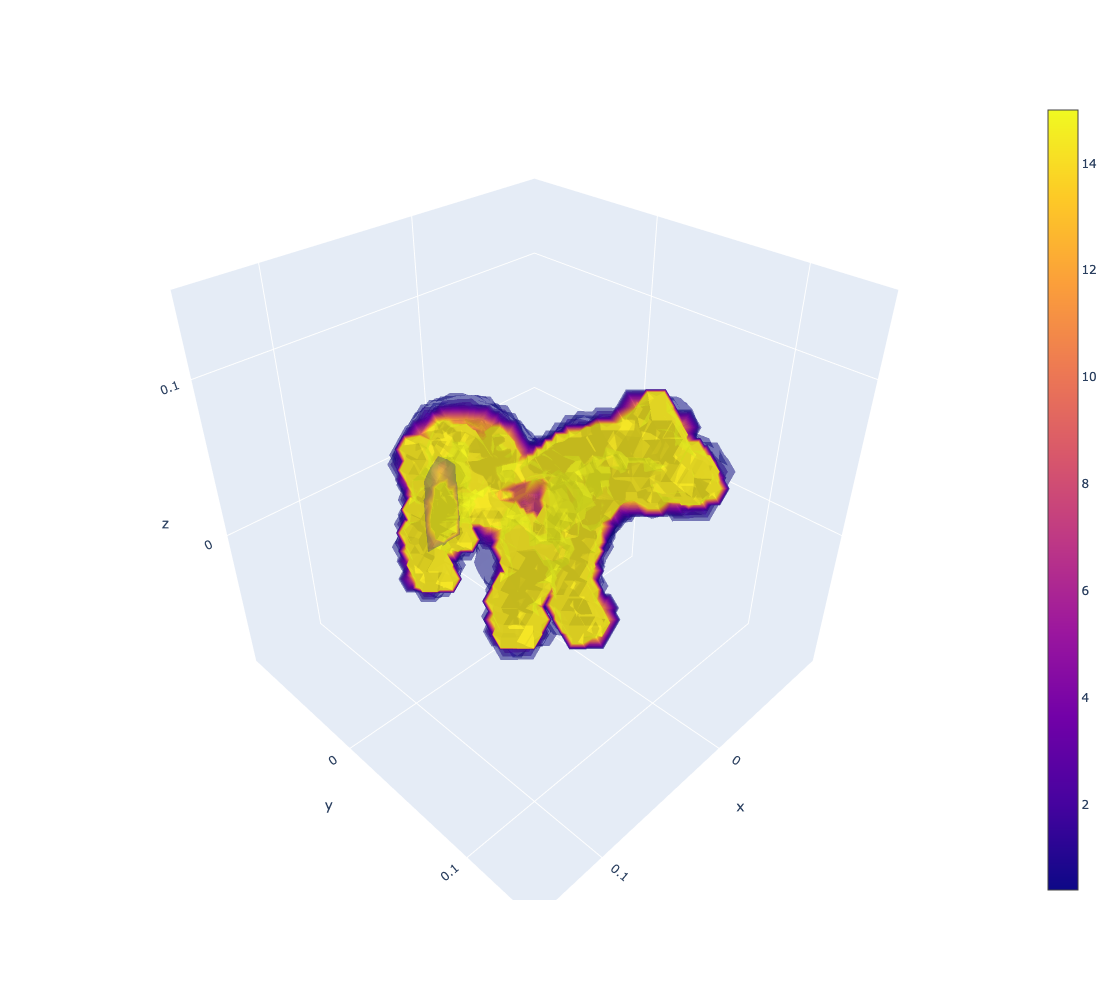

In [129]:
rendu=np.sqrt(values[:,:,:,0]**2+values[:,:,:,1]**2+values[:,:,:,2]**2)
layout = go.Layout(
    autosize=False,
    width=1000,
    height=1000,
    xaxis=go.layout.XAxis(linecolor="black", linewidth=1, mirror=True),
    yaxis=go.layout.YAxis(linecolor="black", linewidth=1, mirror=True),
    margin=go.layout.Margin(l=50, r=50, b=100, t=100, pad=4),
    )
    
fig = go.Figure(data=go.Volume(
x=X[:,:,:].flatten(),
y=Y[:,:,:].flatten(),
z=Z[:,:,:].flatten(),
value=rendu.flatten(),
isomin=0.4,
isomax=15,
opacity=0.3, # needs to be small to see through all surfaces
surface_count=21, # needs to be a large number for good volume rendering
),layout=layout)
fig.show()